# Prevalence inference
I came across this [paper](http://www.sciencedirect.com/science/article/pii/S1053811916303470) from Allefeld, Gorgen, & Haynes (2016) a while ago, in which they discuss that doing a second-level t-test on first-level (i.e., subject-level) classification accuracies (or any other information-based statistic) implies a fixed-effects analysis, which does not warrant any conclusion about a population-level effect (something we aim for in most cognitive neuroscience research). Fortunately, the authors put the code for the implementation of prevalence inference (in the context of MVPA) on [Github](https://github.com/allefeld/prevalence-permutation), albeit MATLAB-based. To understand how this algorithm works (and because no Python-implementation exists thus far), I decided to implement it here. (Also, I plan to incorporate it in my Python package [skbold](https://github.com/lukassnoek/skbold).)

First, some imports:

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook  # pip install tqdm
%matplotlib inline

## Data
We'll simulate some artificial first-level data (i.e., classification accuracies). We'll simulate data for 20 subjects ($N = 20$) for $9 \times 10 \times 9 = 810$ voxels ($K = 810$; an artificially low number of voxels for searchlight-based first-level results, but speeds up the analysis). As such, the true ("observed") first-level data is of shape $20 \times 810$. Furthermore, let's assume that we also ran 100 first-level permutations ($P_{1}$) of the same analysis. As such, the shape of our permutation data is $20 \times 810 \times 100$.

We'll simulate the observed data as samples drawn from a normal distribution with mean 0.6 (i.e., classification accuracy of 60%) and standard deviation 0.05:

\begin{align}
observed = \mathcal{N}(0.55, .05)
\end{align}

Our permutation-data, on the other hand, will be drawn from a normal distribution with mean 0.5 and standard deviation of 0.05:

\begin{align}
permuted = \mathcal{N}(0.5, .05)
\end{align}

In [2]:
N = 20
K = (9, 10, 9)
P1 = 100

obs = np.random.normal(loc=0.55, scale=0.05, size=(N, np.prod(K)))
perms = np.random.normal(loc=0.5, scale=0.05, size=(N, np.prod(K), P1))

print("Observed values shape: %s" % (obs.shape,))
print("Perms shape: %s" % (perms.shape,))

Observed values shape: (20, 810)
Perms shape: (20, 810, 100)


## Analysis
In this section, we'll actually implement (step-by-step) the prevalence 

### Analysis params
First, let's set some analysis-wide parameters. We'll use an (uncorrected) significance threshold, $\alpha$, of 0.05 and we'll run 10000 second-level permutations ($P_{2}$). Later, we'll use a prevalence null statistic, $\gamma_{0}$ of 0.5 (corresponding to the "majority null hypothesis").

In [3]:
alpha = 0.05
P2 = 10000
gamma0 = 0.5

### The minimum statistic
First, we need to calculate the minimum statistic ($m$), which we'll use as the second-level test-statistic. The minimum statistic for any voxel $v$ is calculated across our $N$ subjects with classification accuracies $\hat{a}_{k}$ as (cf. equation 11 from the paper):

\begin{align}
m_{v} = min_{k=1}^{N}\hat{a}_{vk}
\end{align}

In code (note, we'll calculate $m_{v}$ for all $v = 1\ ...\ 810$ voxels at once):

Shape of m: (810,)


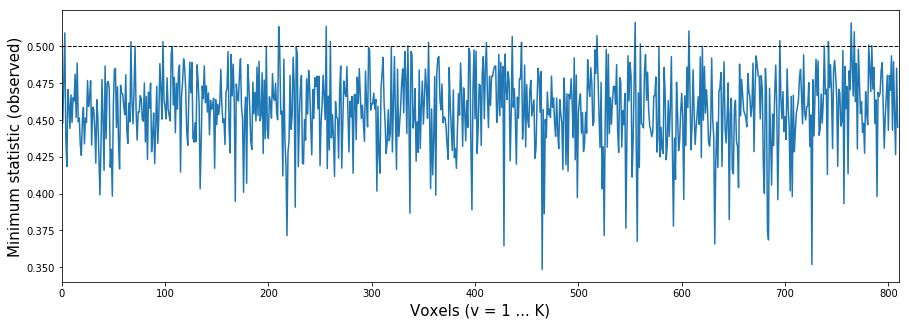

In [4]:
m = np.min(obs, axis=0)
print("Shape of m: %s" % (m.shape,))

plt.figure(figsize=(15, 5))
plt.plot(m)
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel("Minimum statistic (observed)", fontsize=15)
plt.axhline(y=0.5, c='k', ls='--', lw=1)
plt.show()

### The global null hypothesis
Now, the global null hypothesis, corresponding to the hypothesis that all subjects' scores are at chance level ($a_{0}$), is formulated as (cf. equation 12):

\begin{align}
H_{0}: \forall_{k}a_{k} = a_{0}
\end{align}

As such, the negation of the null-hypothesis corresponds to the alternative hypothesis (I think, but this is not explicitly stated in the paper), which can be formulated as:

\begin{align}
H_{a}: \exists_{k}a_{k} > a_{0}
\end{align}

which states that there exists one (or more) subject(s) ($\exists_{k}a_{k}$) that have above-chance accuracy.

We can calculate the p-value corresponding to the null-hypothesis for any observed minimum statistic $m_{v}$ at voxel $v$ as:

\begin{align}
P_{N}(m_{v}) = \frac{1}{P_{2}}\sum_{j=1}^{P_{2}}[m_{v} \leq m_{vj}]
\end{align}

in which $P_{2}$ denotes the number of second-level permutations and $m_{vj}$ the minimum statistic of permutation $j$ at voxel $v$. Thus, the p-value here represents the proportion of instances in which the permutation minimum statistic was higher than the observed minimum statistic. 

First, we need to actually run the second-level permutations, which consist of a randomly drawn first-level permutation per subject: 

In [5]:
mj = np.zeros((np.prod(K), P2))
for j in tqdm_notebook(range(P2)):
    these_perms = np.vstack([perms[k, :, np.random.choice(np.arange(P1), size=1)]
                             for k in range(N)])
    mj[:, j] = these_perms.min(axis=0)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

Now we can calculate the (uncorrected) p-value for the global null hypothesis (`pu_GN`; we'll do this at once for all voxels):

Shape of pu_GN: (810,)
Number of significant voxels: 575


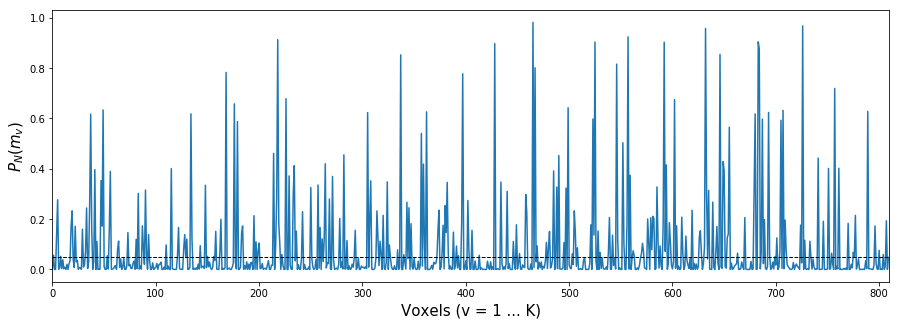

In [13]:
pu_GN = (m[:, np.newaxis] <= mj).sum(axis=1) / P2
print("Shape of pu_GN: %s" % (pu_GN.shape,))
print("Number of significant voxels: %i" % (pu_GN < alpha).sum())

plt.figure(figsize=(15, 5))
plt.plot(pu_GN)
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$P_{N}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.show()

We should, of course, correct for multiple comparisons. This can be done by calculating the *maximum* statistic across all $P_{2}$ permutations. Then, we can use the distribution of maximum statistic values ($M_{j}$ across $j = 1\ ...\ P_{2}$ permutations):

\begin{align}
M_{j} = max_{v}m_{vj}
\end{align}

In [7]:
max_stats = mj.max(axis=0)
print("Shape max stats: %s" % (max_stats.shape,))

Shape max stats: (10000,)


Then, the *corrected* p-value corresponding to the global null hypothesis (`pc_GN`) can be calculated as:

\begin{align}
P_{N}^{*}(M_{v}) = \frac{1}{P_{2}}\sum_{j=1}^{P_{2}}[m_{v} \leq M_{j}]
\end{align}

And in code:

Shape of pc_GN: (810,)
Number of significant voxels: 114


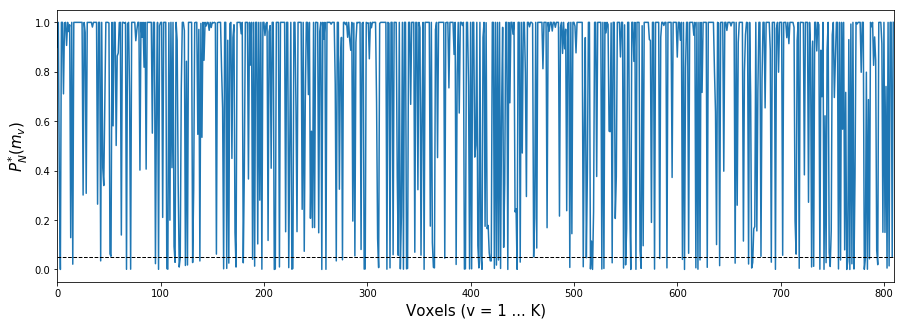

In [8]:
pc_GN = (m[:, np.newaxis] <= max_stats).sum(axis=1) / P2
print("Shape of pc_GN: %s" % (pc_GN.shape,))
print("Number of significant voxels: %i" % (pc_GN < alpha).sum())

plt.figure(figsize=(15, 5))
plt.plot(pc_GN)
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.show()

### The prevalence null hypothesis
In contrast to the global null hypothesis, the prevalence null hypothesis tests whether the prevalence of an effect is smaller or equal to some threshold prevalence ($\gamma_{0}$):

\begin{align}
H_{0}: \gamma \leq \gamma_{0}
\end{align}

And, correspondingly, the alternative hypothesis becomes (although I'm not sure of this; it's not explicitly in the paper):

\begin{align}
H_{a}: \gamma > \gamma_{0}
\end{align}

We can express the (uncorrected) prevalance null p-value for any threshold $\gamma_{0}$:

\begin{align}
P_{N}(m \mid \gamma \leq \gamma_{0}) = [(1 - \gamma_{0})\ \sqrt[N]{P_{N}(m)} + \gamma_{0}]^{N} 
\end{align}

Let's do that below:

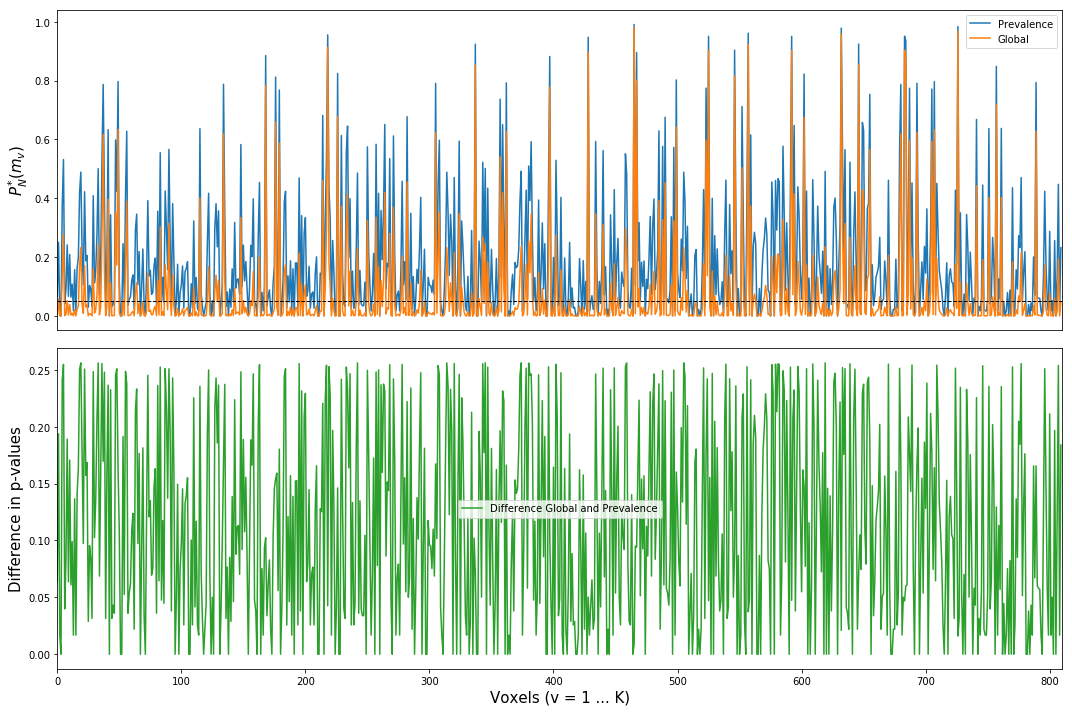

In [14]:
pu_MN = ((1 - gamma0) * pu_GN ** (1 / N) + gamma0) ** N
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(pu_MN)
plt.plot(pu_GN)
plt.xticks([])
plt.legend(['Prevalence', 'Global'])
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)

plt.subplot(2, 1, 2)
plt.plot(pu_MN - pu_GN, c='tab:green')
plt.legend(['Difference Global and Prevalence'])
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel("Difference in p-values", fontsize=15)

plt.tight_layout()
plt.show()

As you can see, the p-values of the prevalence hypothesis are more conservative than those corresponding to the global null hypothesis. Of course, given that we test a bunch of voxels, we need to correct for multiple comparisons. The formula for this is quite similar to the previous one:

\begin{align}
P_{N}^{*}(m \mid \gamma \leq \gamma_{0}) = [(1 - \gamma_{0})\ \sqrt[N]{P_{N}^{*}(m)} + \gamma_{0}]^{N} 
\end{align}

which is implemented below:

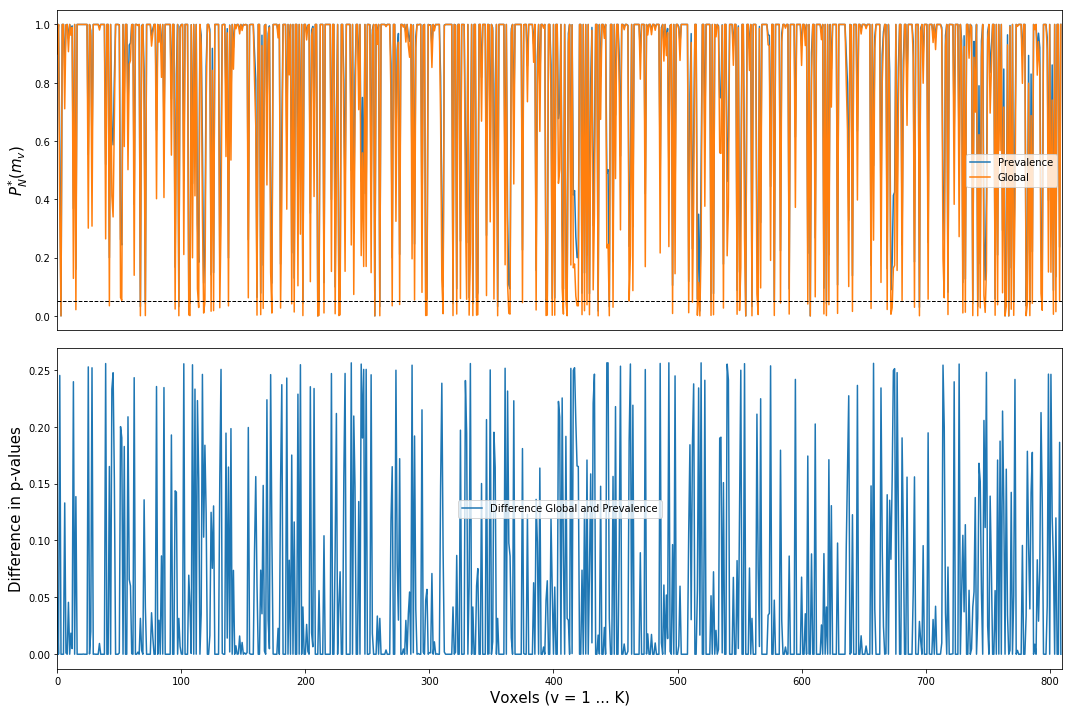

In [15]:
pc_MN = ((1 - gamma0) * pc_GN ** (1 / N) + gamma0) ** N
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(pc_MN)
plt.plot(pc_GN)
plt.legend(['Prevalence', 'Global'])
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.xticks([])

plt.subplot(2, 1, 2)
plt.plot(pc_MN - pc_GN)
plt.legend(['Difference Global and Prevalence'])
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel("Difference in p-values", fontsize=15)

plt.tight_layout()
plt.show()

### Comparison with second-level t-test
Let's check what the actual second-level t-value would yield in terms of p-values. First the parametric version:

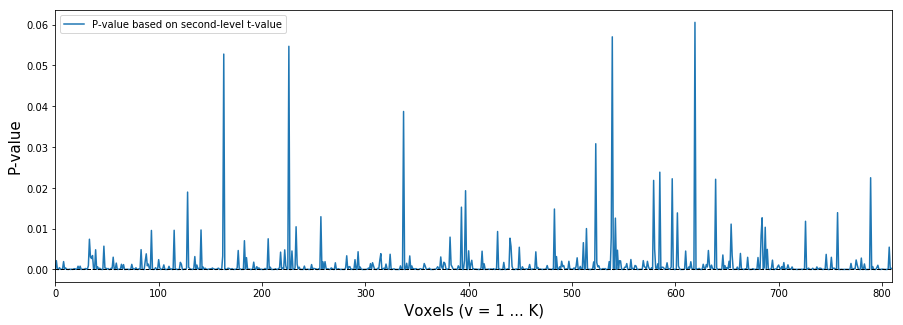

In [16]:
from scipy import stats
tvals = (obs.mean(axis=0) - 0.5) / (obs.std(axis=0) / np.sqrt(N))
pvals = stats.t.sf(tvals, df = N - 1)

plt.figure(figsize=(15, 5))
plt.plot(pvals)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel('P-value', fontsize=15)
plt.xlim(0, np.prod(K))
plt.axhline(y=alpha/pvals.size, lw=1, ls='--', c='k')
plt.legend(["P-value based on second-level t-value"])
plt.show()

... and the non-parametric permutation based one:

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

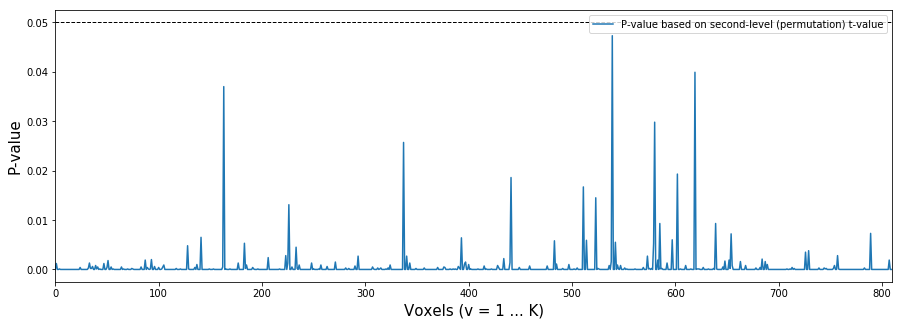

In [17]:
mean_perms = np.zeros((np.prod(K), P2))
for j in tqdm_notebook(range(P2)):
    these_perms = np.vstack([perms[k, :, np.random.choice(np.arange(P1), size=1)]
                             for k in range(N)])
    mean_perms[:, j] = these_perms.mean(axis=0)

pvals_perm = np.sum(obs.mean(axis=0)[:, np.newaxis] < mean_perms, axis=1) / P2

plt.figure(figsize=(15, 5))
plt.plot(pvals_perm)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel('P-value', fontsize=15)
plt.xlim(0, np.prod(K))
plt.axhline(y=alpha, lw=1, ls='--', c='k')
plt.legend(["P-value based on second-level (permutation) t-value"])
plt.show()

## Check real data
Check whether we get (approximately) the same output as the original implementation in MATLAB.

In [18]:
from glob import glob
import os.path as op
import nibabel as nib

data_dir = '/Users/lukas/software/prevalence-permutation/cichy-2011-category-smoothedaccuracy-1.0.0/'
sub_dirs = sorted(glob(op.join(data_dir, '??')))

all_data = []

for sub_dir in sub_dirs:
    
    perm_files = sorted(glob(op.join(sub_dir, '*')))
    all_data.append([nib.load(p).get_data().ravel() for p in perm_files])

all_data = np.stack([np.stack(all_data[i], axis=-1) for i in range(len(all_data))], axis=0)

Let's remove all voxels that have any NaN in there.

In [19]:
any_nan = np.isnan(all_data).sum(axis=(0, 2)) > 0 
all_data_nonzero = all_data[:, np.invert(any_nan), :]

And split the data into the 'real' (observed) statistics ($i = 1$) and the permuted statistics ($i = 2\ ...\ 16$).

In [20]:
obs_r = all_data_nonzero[:, :, 0]
perms_r = all_data_nonzero[:, :, 1:]

print("Observed data shape: %s" % (obs_r.shape,))
print("Permuted data shape: %s" % (perms_r.shape,))

N_r, K_r, P1_r = perms_r.shape
P2_r = 1000

Observed data shape: (12, 48999)
Permuted data shape: (12, 48999, 15)


In [21]:
m_r = np.min(obs_r, axis=0)
mj_r = np.zeros((K_r, P2_r))
for j in tqdm_notebook(range(P2_r)):
    these_perms = np.vstack([perms_r[k, :, np.random.choice(np.arange(P1_r), size=1)]
                             for k in range(N_r)])
    mj_r[:, j] = these_perms.min(axis=0)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [22]:
pu_GN_r = (m_r[:, np.newaxis] <= mj_r).sum(axis=1) / P2_r
max_stats_r = mj_r.max(axis=0)
pc_GN_r = (m_r[:, np.newaxis] <= max_stats_r).sum(axis=1) / P2_r
pu_MN_r = ((1 - gamma0) * pu_GN_r ** (1 / N_r) + gamma0) ** N_r
pc_MN_r = ((1 - gamma0) * pc_GN_r ** (1 / N_r) + gamma0) ** N_r

Let's try some plotting:

In [23]:
from nilearn.plotting import plot_stat_map

#### Global null (corrected)

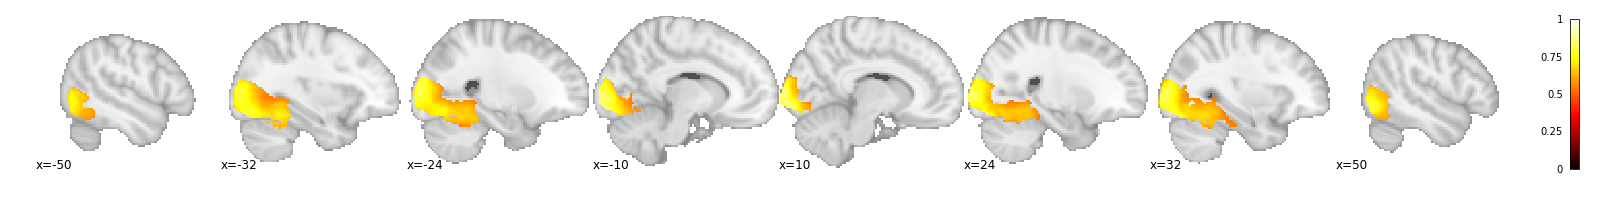

In [24]:
affine = nib.load(perm_files[0]).affine

statsr = np.median(obs_r, axis=0)
statsr[pc_GN_r > 0.05] = 0
pc_GN_img = np.zeros((91, 109, 91)).ravel()
pc_GN_img[np.invert(any_nan)] = statsr
pc_GN_img = nib.Nifti1Image(pc_GN_img.reshape((91, 109, 91)), affine=affine)

plot_stat_map(pc_GN_img, display_mode='x', vmax=1, cut_coords=[-50, -32, -24, -10, 10, 24, 32, 50])
plt.show()

#### Prevalence null (corrected)

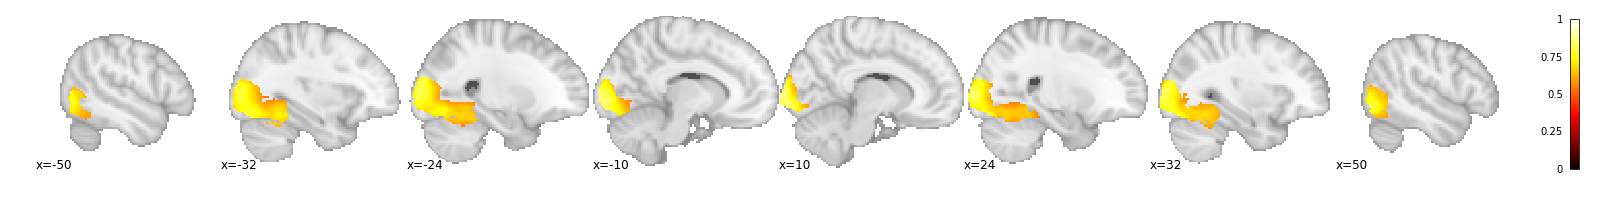

In [25]:
statsr = np.median(obs_r, axis=0)
statsr[pc_MN_r > 0.05] = 0
pc_MN_img = np.zeros((91, 109, 91)).ravel()
pc_MN_img[np.invert(any_nan)] = statsr
pc_MN_img = nib.Nifti1Image(pc_MN_img.reshape((91, 109, 91)), affine=affine)

plot_stat_map(pc_MN_img, display_mode='x', vmax=1, cut_coords=[-50, -32, -24, -10, 10, 24, 32, 50])
plt.show()

#### Second-level t-test (bonferroni corrected)

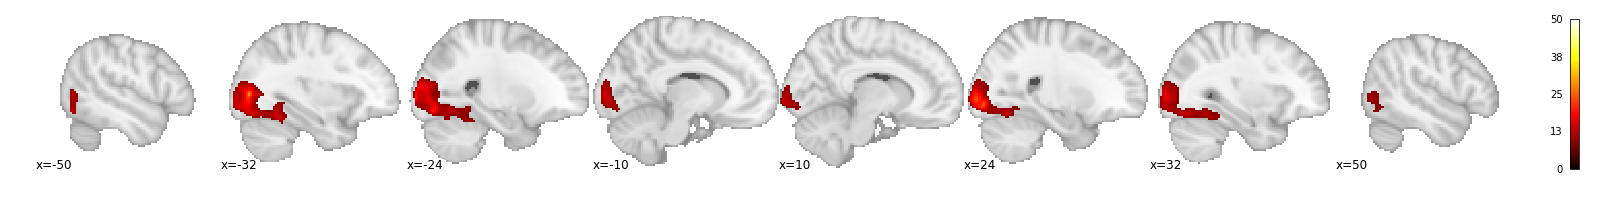

In [26]:
tstats_r  = (obs_r.mean(axis=0) - 0.5) / (obs_r.std(axis=0) / np.sqrt(N_r - 1))
pvals_r = stats.t.sf(tstats_r, df=N_r - 1) 
tstats_r[pvals_r > alpha / tstats_r.size] = 0
tstat_img = np.zeros((91, 109, 91)).ravel()
tstat_img[np.invert(any_nan)] = tstats_r
tstat_img = nib.Nifti1Image(tstat_img.reshape((91, 109, 91)), affine=affine)

plot_stat_map(tstat_img, display_mode='x', cut_coords=[-50, -32, -24, -10, 10, 24, 32, 50])
plt.show()

Seems to correspond roughly with figure 4 from the paper!

## ToDo

\begin{align}
\alpha^{*}_{max} = \frac{\alpha - 1\ /\ \mathrm{P_{2}}}{1 - 1\ /\ \mathrm{P_{2}}}
\end{align}

\begin{align}
y_{0\ max} = \frac{\sqrt[N]{\alpha^{*}_{max}} - \sqrt[N]{1\ /\ P_{2}}}{1 - \sqrt[N]{1\ /\ P_{2}}}
\end{align}

In [ ]:
alpha_max = (alpha - 1 / P2) / (1 - 1 / P2)
y0_max = (alpha_max ** (1 / N) - (1 / P2) ** (1 / N)) / (1 - (1 / P2) ** (1 / N))